In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def roundTime(dt=None):    
    dt = dt.to_pydatetime()
    roundTo = 15*60    
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)


def strip_time(timestr):
    return timestr[5:-4]

def calc_charging_time(row):
    end = row['doneChargingTime']
    start = row['connectionTime']
    dur_sec = (end - start).total_seconds()
    return dur_sec/60.0

def calc_quarter_load(row):
    dur = row['sessionDuration']
    total = row['kWhDelivered']
    return (total/dur)*15.0

def add_to_backbone(row):
    iters = int(row['sessionDuration']//15)
    for i in range(iters):
        backbone.loc[backbone['date_time'] == row['connectionTime'] + datetime.timedelta(minutes=15*i), 'value'] += row['loadPerQuarter'] 
        backbone.loc[backbone['date_time'] == row['connectionTime'] + datetime.timedelta(minutes=15*i), 'sessions'] += 1    

In [3]:
f = open('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/acndata_sessions.json')
data = json.load(f)
sites = set()
print(len(data['_items']))

31424


In [4]:
dfdata = []
columns=['_id','clusterID','connectionTime','disconnectTime','doneChargingTime','kWhDelivered','sessionID', 'siteID', 'spaceID', 'stationID', 'timezone']

for i in data['_items']:    
    dfdata.append([i['_id'],i['clusterID'],i['connectionTime'],i['disconnectTime'],i['doneChargingTime'],i['kWhDelivered'], i['sessionID'],i['siteID'],i['spaceID'],i['stationID'],i['timezone']])
    
df = pd.DataFrame(dfdata, columns=columns)

In [5]:
df = df[df['connectionTime'].notna()]
df = df[df['doneChargingTime'].notna()]
df = df[df['disconnectTime'].notna()]
df['connectionTime'] = df['connectionTime'].apply(strip_time)
df['doneChargingTime'] = df['doneChargingTime'].apply(strip_time)
df['disconnectTime'] = df['disconnectTime'].apply(strip_time)
df['connectionTime'] = df['connectionTime'].map(lambda x: datetime.datetime.strptime(x, '%d %b %Y %H:%M:%S'))
df['doneChargingTime'] = df['doneChargingTime'].map(lambda x: datetime.datetime.strptime(x, '%d %b %Y %H:%M:%S'))
df['disconnectTime'] = df['disconnectTime'].map(lambda x: datetime.datetime.strptime(x, '%d %b %Y %H:%M:%S'))
df['connectionTime'] = df['connectionTime'].map(roundTime)
df['doneChargingTime'] = df['doneChargingTime'].map(roundTime)
df['disconnectTime'] = df['disconnectTime'].map(roundTime)
exclude_stations = ['2-39-83-387', '2-39-82-384', '2-39-82-385', '2-39-81-4550']
df = df[df['stationID'].isin(exclude_stations) == False]
df['sessionDuration'] = df.apply(lambda row: calc_charging_time(row), axis=1)
df = df[df['sessionDuration'] > 0.0]
df['loadPerQuarter'] = df.apply(lambda row: calc_quarter_load(row), axis=1)



In [12]:

df.siteID
list(df)
set(list(df.clusterID))

{'0039', 39}

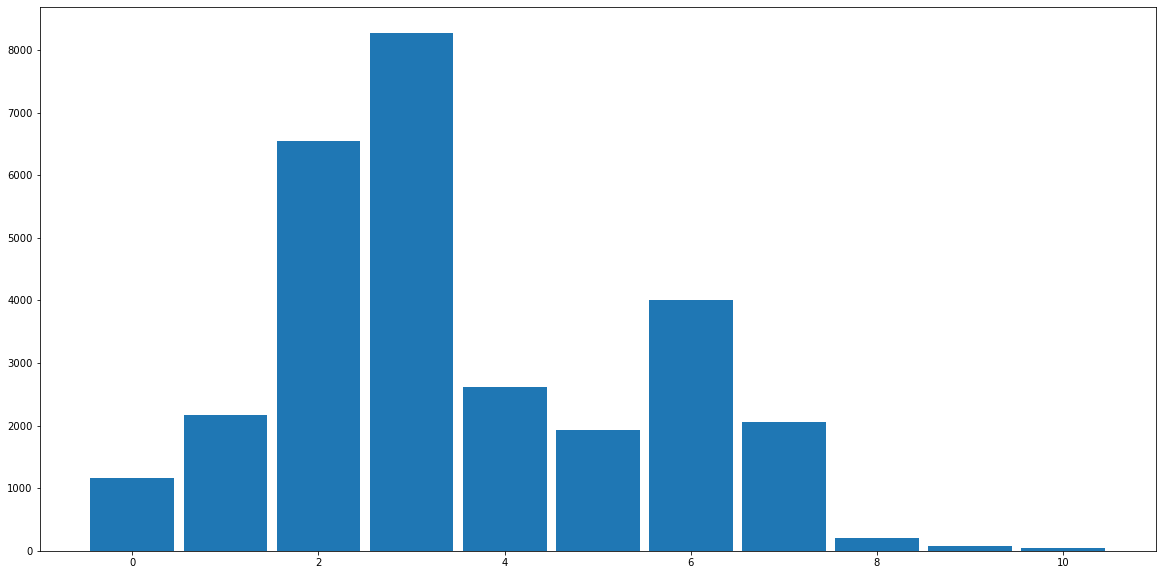

['_id',
 'clusterID',
 'connectionTime',
 'disconnectTime',
 'doneChargingTime',
 'kWhDelivered',
 'sessionID',
 'siteID',
 'spaceID',
 'stationID',
 'timezone',
 'sessionDuration',
 'loadPerQuarter',
 'power']

In [13]:
def calc_power(row):
    dur = row['sessionDuration']
    energy = row['kWhDelivered']
    return round((energy/dur)*60)
    
df['power'] = df.apply(lambda row: calc_power(row), axis=1)


list(df)
np.mean(df.power)

vc_power = df.power.value_counts()
vc_power = vc_power.sort_index()
vc_power = vc_power[:11]
x_power = vc_power.index
y_power = vc_power.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_power, y_power, width=0.9)
plt.show()

list(df)


In [14]:
start = df['connectionTime'].min()
# start = datetime.datetime.strptime("2020/03/15 00:00:00+00", '%Y/%m/%d %H:%M:%S+%f')
end = datetime.datetime.strptime("2020/03/15 00:00:00+00", '%Y/%m/%d %H:%M:%S+%f')
# end = df['disconnectTime'].max()
backbone = pd.DataFrame({'date_time': pd.date_range(start, end, freq="15min")})
backbone.set_index('date_time')
backbone['value'] = 0.0
backbone['sessions'] = 0

In [15]:
print(start)

2018-04-25 11:15:00


In [28]:
from scipy import stats
df['z_score'] = np.abs(stats.zscore(df['sessionDuration']))
df = df[df.z_score <= 3.0]

In [29]:
df.apply(lambda row: add_to_backbone(row), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
31416    None
31417    None
31419    None
31420    None
31422    None
Length: 28943, dtype: object

In [30]:
backbone_daily = pd.DataFrame({'date_time': pd.date_range(start, end, freq="24h")})
backbone_daily['value'] = 0.0
backbone_daily['sessions'] = 0
backbone_daily = backbone_daily[:-1]


    
for row in backbone_daily.itertuples():
    avg_load = 0.0
    avg_sessions = 0
    start_time = backbone_daily.at[row.Index, 'date_time']
    for i in range(96):
        avg_load += backbone[backbone['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['value'].item()    
        avg_sessions += backbone[backbone['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['sessions'].item()
    avg_load /= 96.0    
    backbone_daily.loc[row.Index, 'value'] = avg_load  
    backbone_daily.loc[row.Index, 'sessions'] = avg_sessions     
    


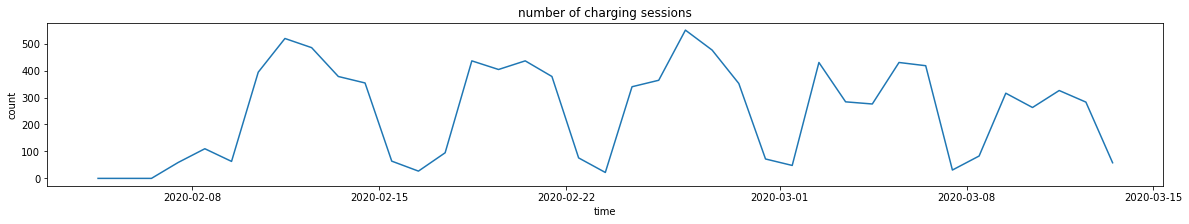

In [31]:
x_sessions = backbone_daily['date_time']
y_sessions = backbone_daily['sessions']
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(x_sessions[650:750], y_sessions[650:750])
plt.xlabel("time")
plt.ylabel("count")
plt.title("number of charging sessions")
plt.show()

In [32]:
len(x_sessions)

689

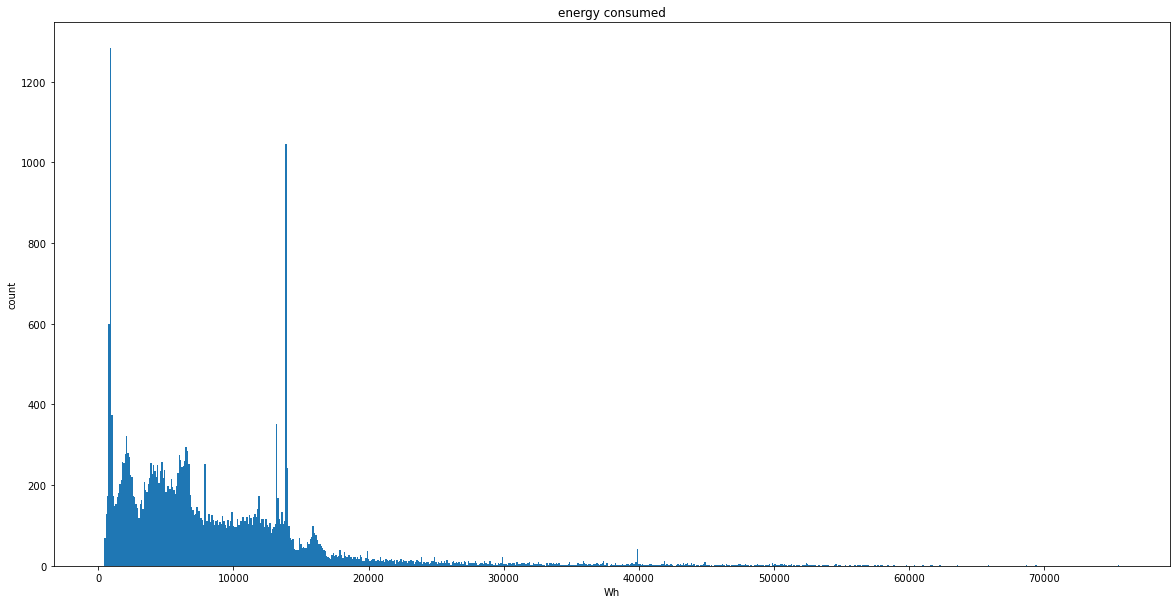

In [33]:
import matplotlib.pyplot as plt

df['WhDelivered'] = df['kWhDelivered'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = df.WhDelivered.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_energy.png')
plt.show()

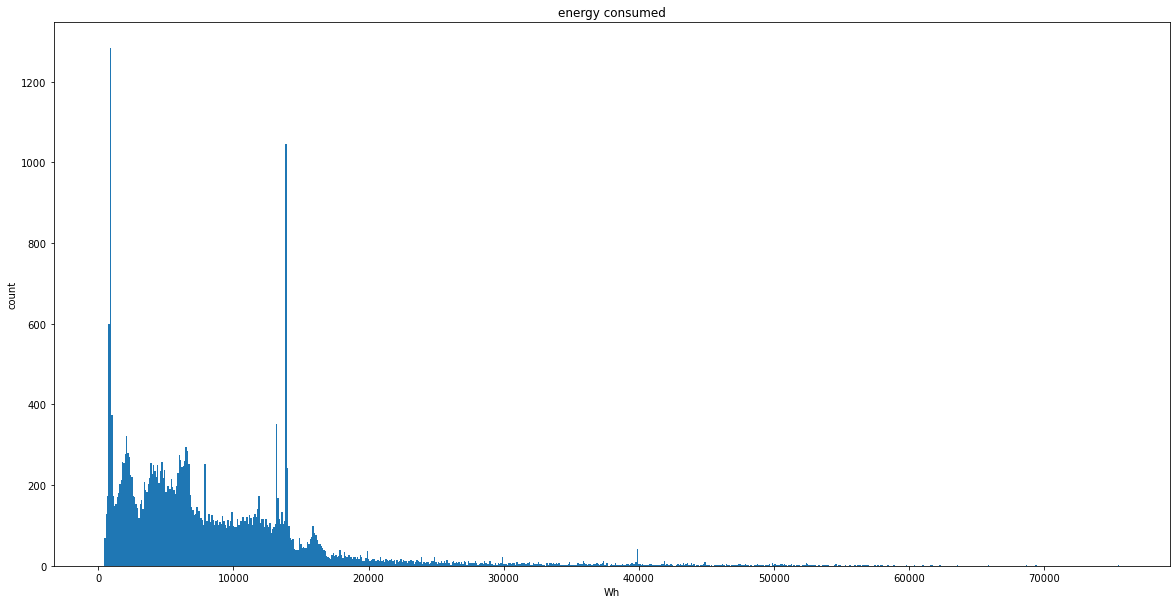

In [34]:
import matplotlib.pyplot as plt

df['WhDelivered'] = df['kWhDelivered'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = df.WhDelivered.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_energy.png')
plt.show()

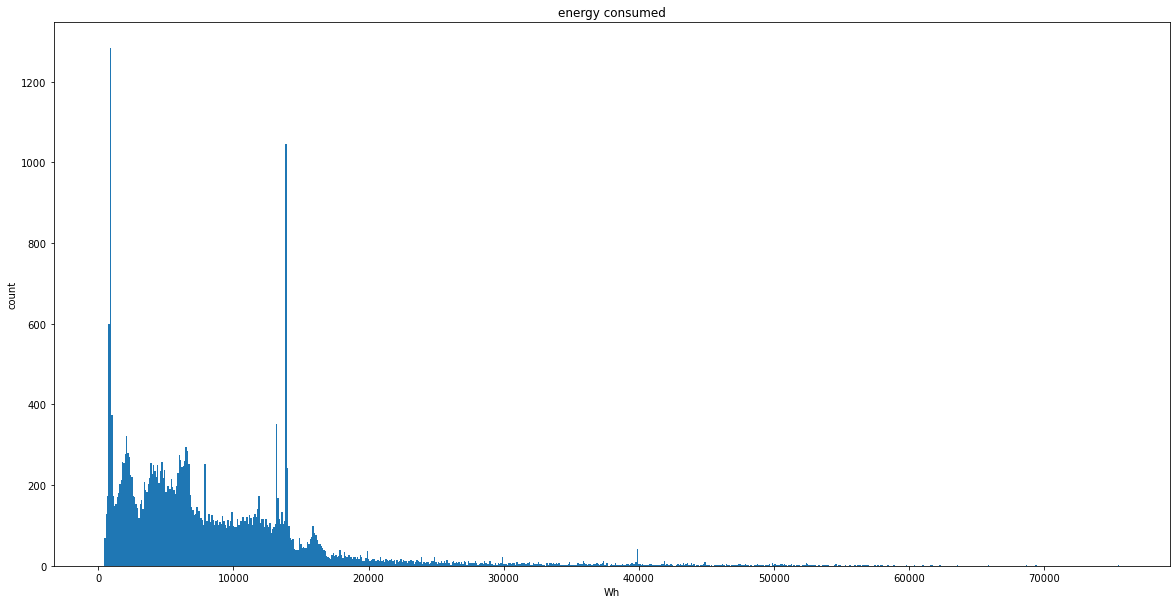

In [35]:
import matplotlib.pyplot as plt

df['WhDelivered'] = df['kWhDelivered'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = df.WhDelivered.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Post_covid/acn_energy.png')
plt.show()

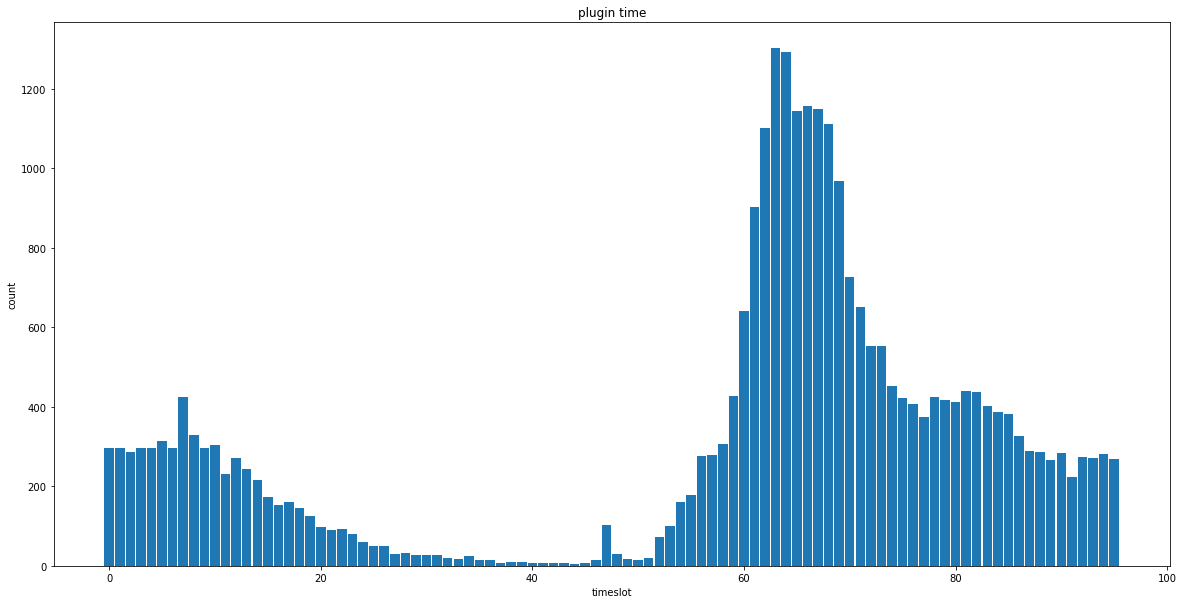

In [36]:
list(df)
df.connectionTime

def get_hs_and_mins(ts):
    hours = str(ts.hour)
    minutes = str(ts.minute)
    if hours == '0':
        hours = '00'
    if minutes == '0':
        minutes = '00'        
    ts = datetime.datetime.strptime(hours + ":" + minutes, '%H:%M')    
    return ts
    
df['plugin_time'] = df['connectionTime'].map(get_hs_and_mins)
vc_plugin = df.plugin_time.value_counts()
vc_plugin = vc_plugin.sort_index()


x_plugin = vc_plugin.index
x_plugin = range(96)
y_plugin = vc_plugin.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_plugin, y_plugin, width=0.9)
plt.xlabel("timeslot")
plt.ylabel("count")
plt.title("plugin time")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_plugin_time.png')
plt.show()

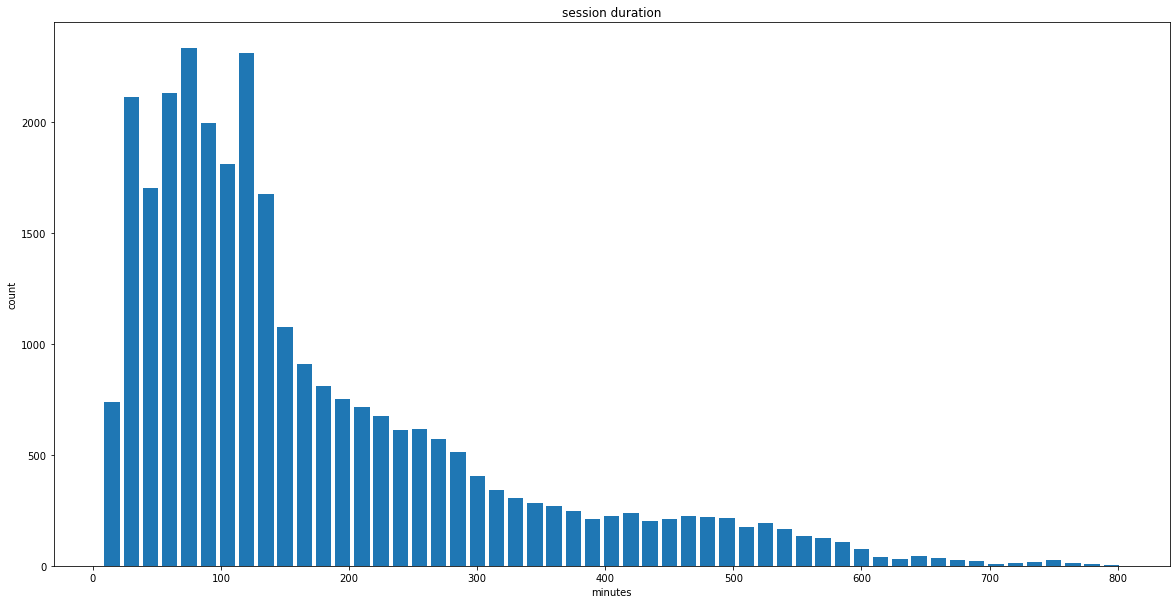

In [37]:
list(df)
df.sessionDuration

vc_duration = df['sessionDuration'].value_counts()
vc_duration = vc_duration[vc_duration.values > 1]
vc_duration = vc_duration.sort_index()
x_duration = vc_duration.index
y_duration = vc_duration.values

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_duration, y_duration, width=12)

plt.xlabel("minutes")
plt.ylabel("count")
plt.title("session duration")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_session_duration.png')
plt.show()


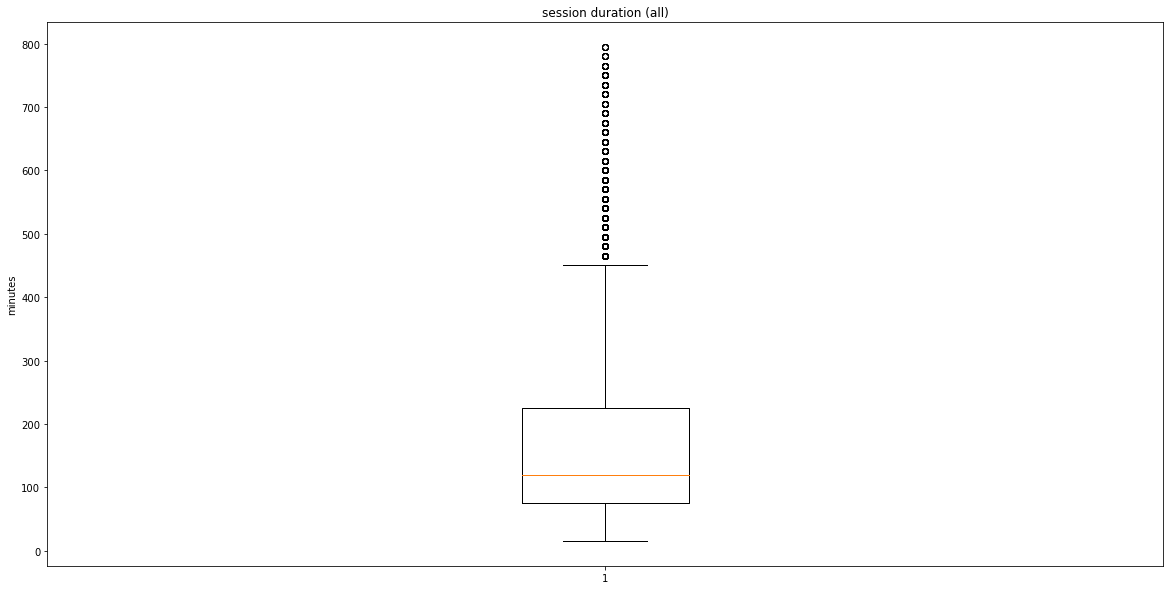

In [38]:
df['sessionDuration']
list(df)
df.connectionTime

plt.boxplot(df['sessionDuration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (all)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_box_all.png')
plt.show()

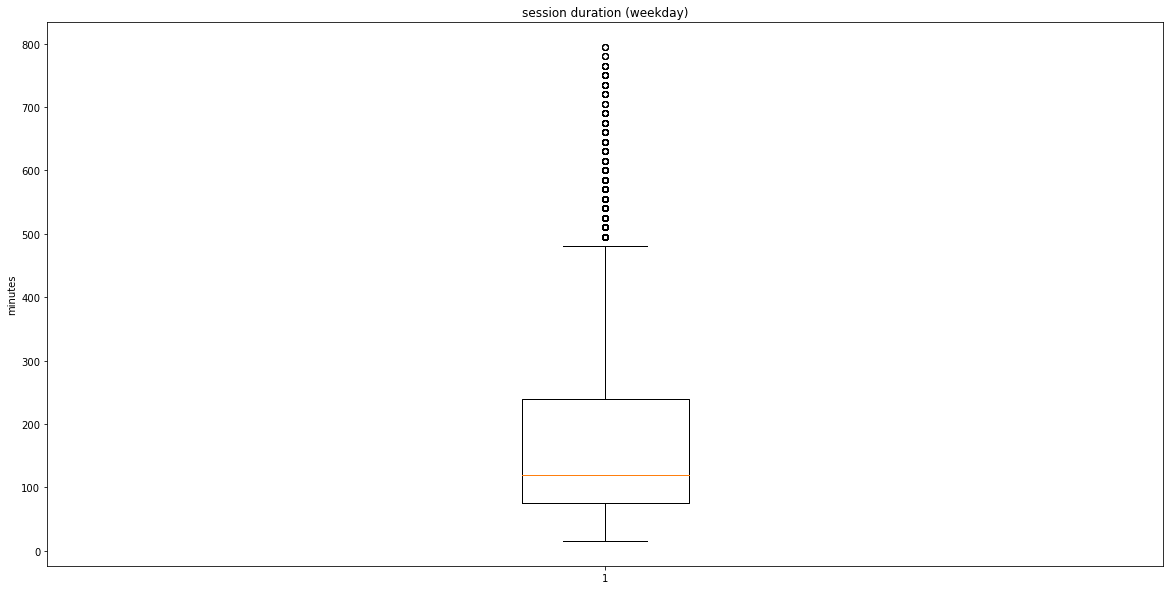

In [39]:
def get_weekend(ts):
    if ts.weekday() > 4:
        return 1
    return 0

df['weekend'] = df['connectionTime'].apply(get_weekend)

df_weekday = df[df['weekend'] == 0]
df_weekend = df[df['weekend'] == 1]


plt.boxplot(df_weekday['sessionDuration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekday)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_box_weekday.png')
plt.show()

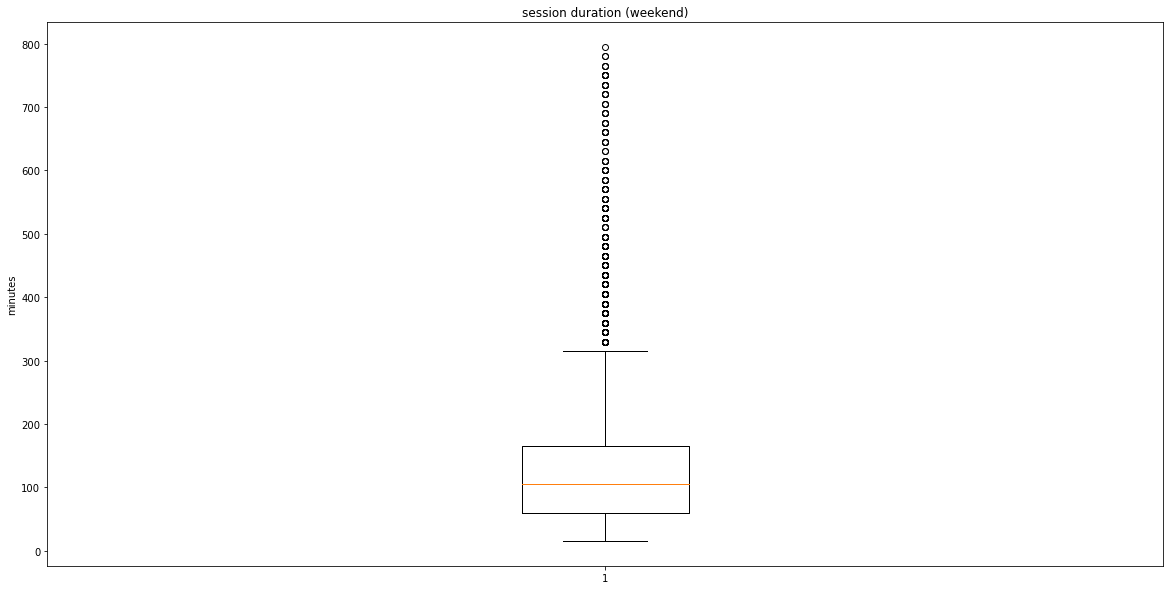

In [44]:
plt.boxplot(df_weekend['sessionDuration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekend)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_box_weekend.png')
plt.show()

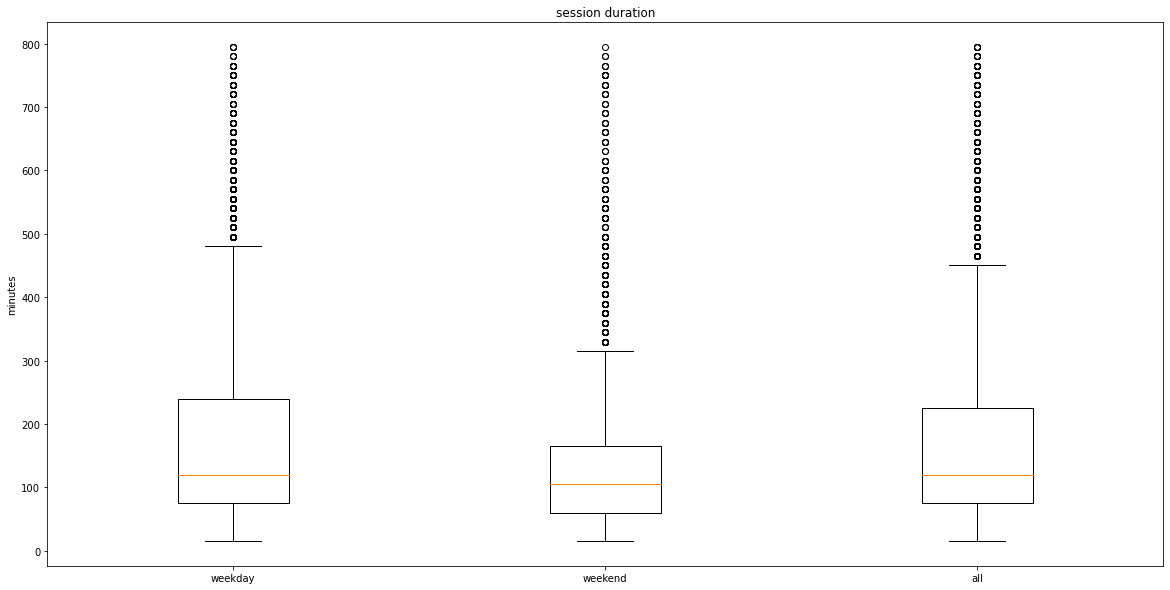

In [45]:
value_dict = {'weekday': df_weekday['sessionDuration'], 'weekend': df_weekend['sessionDuration'], 'all': df['sessionDuration']}

fig, ax = plt.subplots()
ax.boxplot(value_dict.values())
ax.set_xticklabels(value_dict.keys())
plt.rcParams["figure.figsize"] = (20,10)
plt.ylabel("minutes")
plt.title("session duration") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/acn_boxes.png')
plt.show()

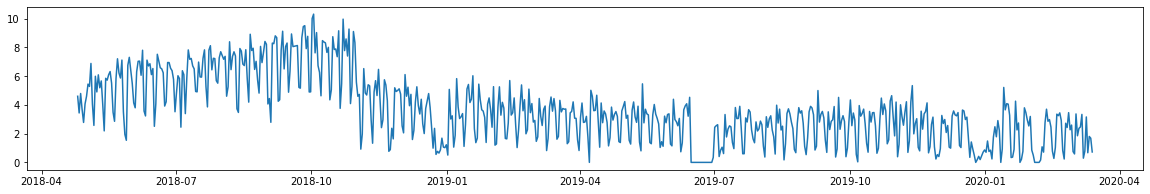

In [42]:
import matplotlib.pyplot as plt


x = backbone_daily['date_time']
y = backbone_daily['value']  


plt.rcParams["figure.figsize"] = (20,3)
plt.plot(x, y)
plt.show()